# News Mood on Twitter

### Analysis - Based on last 100 tweets from 5 news channels [ BBC, CBS, CNN, FoxNews, NYTimes ] 

-  Observed Trend 1: CBS has tweeted most tweets with (+)ve compound score (i.e. has most positive sentiments)

-  Observed Trend 2: NYT has tweeted most tweets with (-)ve compound score (i.e. has most negative sentiments)

-  Observed Trend 3: Most tweets have compound score of 0 i.e. tend to be of overall neutral sentiment.

In [1]:
# Dependencies
import tweepy
import json
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import datetime


dt = datetime.datetime.today().strftime('%m/%d/%y')
analyzer = SentimentIntensityAnalyzer()

# Extract API key from external json file
keyPairs = open('../../keys/appkey.json')
keyPairs_json = json.load(keyPairs)
consumer_key = keyPairs_json['twtconkey']
consumer_secret = keyPairs_json['twtconsec']
access_token = keyPairs_json['twtacctok']
access_token_secret = keyPairs_json['twtaccsec']

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

colorLst = ['skyblue','green','red','blue','yellow']

### Pull data from Twitter

In [2]:
# Target User Accounts
target_user = ["@BBC","@CBS","@CNN","@FoxNews","@nytimes"]

twtIndex = 0
twtData = pd.DataFrame([])
twtData['Tweets Ago'] = ""
twtData['Negative Sentiments'] = ""
twtData['Neutral Sentiments'] = ""
twtData['Positive Sentiments'] = ""
twtData['Compound Sentiments'] = ""

# Loop through each user
for user in target_user:
    
    tweetsAgo = 0

    # iterate through specified no. of pages (each page has 20 tweets)
    for page in tweepy.Cursor(api.user_timeline, id=user, wait_on_rate_limit=True, wait_on_rate_limit_notify=True).pages(5):

        # iterate through each tweet in the page
        for tweet in page:
            tweetInfo = json.dumps(tweet._json, indent=3)
            tweetInfo = json.loads(tweetInfo)
            # Target String Setting
            target_string = tweetInfo['text']
            
            # Analyze the sentiment of the tweet
            sentmt = analyzer.polarity_scores(target_string)
            
            twtInfo_tmp = json_normalize(tweet._json)
            twtData = twtData.append(twtInfo_tmp)
            twtData.iloc[twtIndex, twtData.columns.get_loc('Tweets Ago')] = tweetsAgo
            twtData.iloc[twtIndex, twtData.columns.get_loc('Negative Sentiments')] = sentmt['neg']
            twtData.iloc[twtIndex, twtData.columns.get_loc('Neutral Sentiments')] = sentmt['neu']
            twtData.iloc[twtIndex, twtData.columns.get_loc('Positive Sentiments')] = sentmt['pos']
            twtData.iloc[twtIndex, twtData.columns.get_loc('Compound Sentiments')] = sentmt['compound']

            tweetsAgo = tweetsAgo + 1
            twtIndex = twtIndex + 1


### Filter required columns and save data into a csv

In [3]:
twtData1 = twtData[['user.name','text','Tweets Ago','created_at','Compound Sentiments', 'Negative Sentiments', 'Neutral Sentiments', 'Positive Sentiments']]
twtData1 = twtData1.rename(columns={'created_at':'Created At','user.name':'User','text':'Tweet'})
df = twtData1.copy()
df.to_csv('MediaSentiments.csv')

### Draw a Scatter Plot for Compound Sentiments of tweets from all 5 News outlets

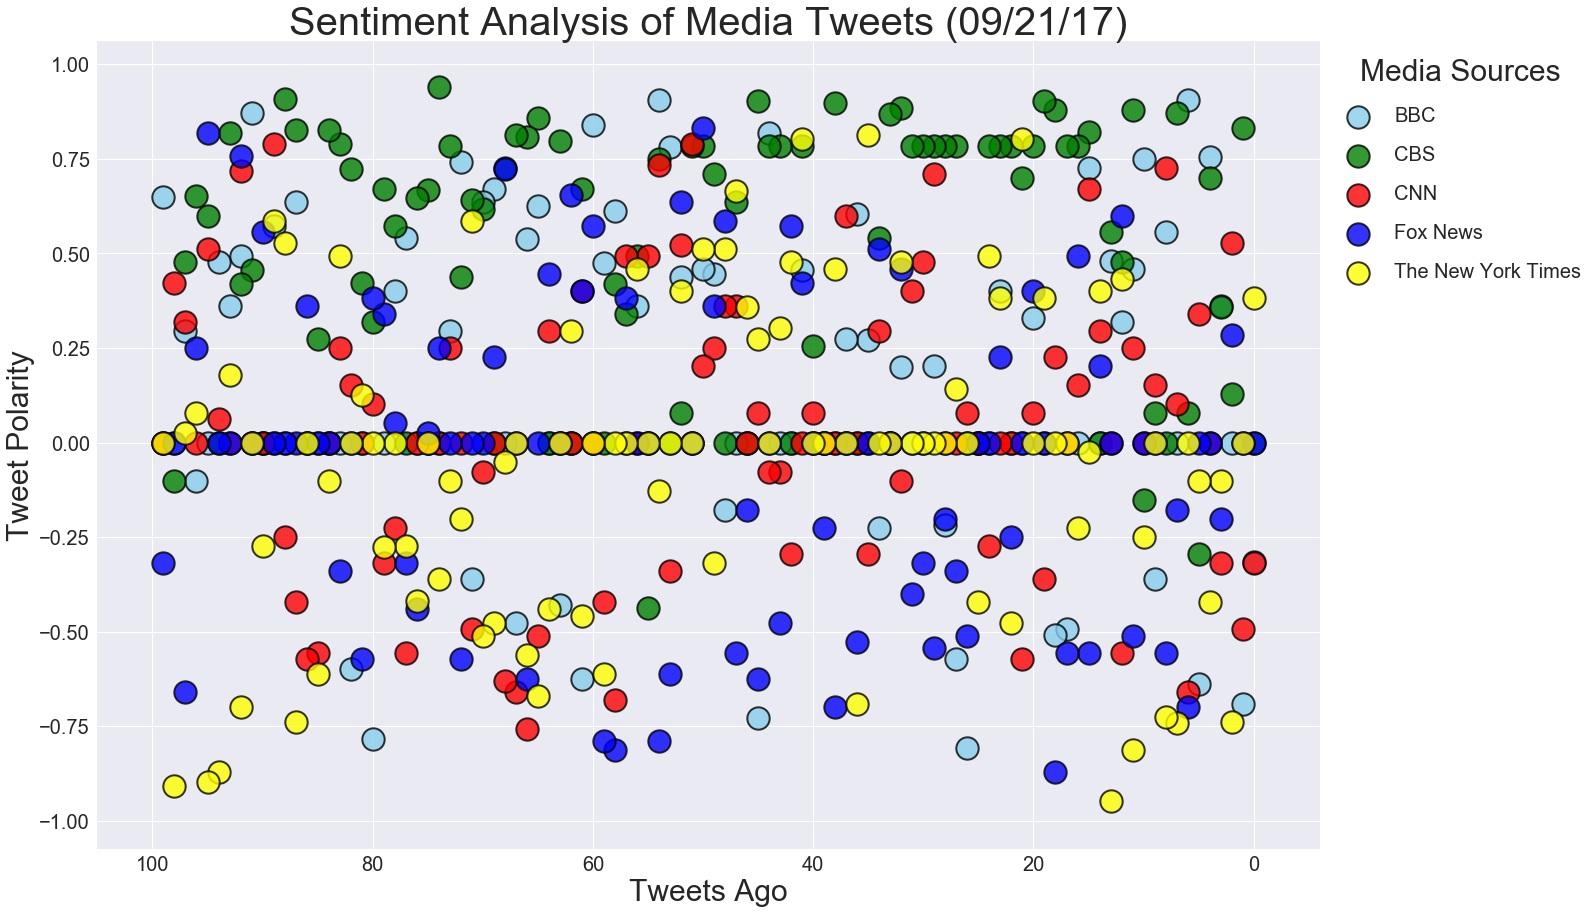

In [4]:
g = sns.lmplot(x='Tweets Ago',y='Compound Sentiments', data=df, palette=colorLst, hue='User', legend=False, fit_reg=False, size =12, aspect=1.5, scatter_kws={'s': 500, 'linewidths':2,'edgecolor':'k'})
g = plt.gca()
g.invert_xaxis()
for tick in g.get_xticklabels():
    tick.set_fontsize(20)
for tick in g.get_yticklabels():
    tick.set_fontsize(20)
plt.xlabel('Tweets Ago', fontsize=30)
plt.ylabel('Tweet Polarity', fontsize=30)
plt.title('Sentiment Analysis of Media Tweets (' + dt + ')', fontsize=40)
lg = plt.legend(title='Media Sources',bbox_to_anchor=(1, 1), loc='upper left', ncol=1, labelspacing=1, prop={'size': 20})
lg.get_title().set_fontsize(30)
plt.savefig('SentimentAnalysis_Scatter.png', bbox_inches='tight')
plt.show()

### Draw a Bar Chart to show Overall News Sentiments (i.e. Mean Compound Sentiments for each News Channel)

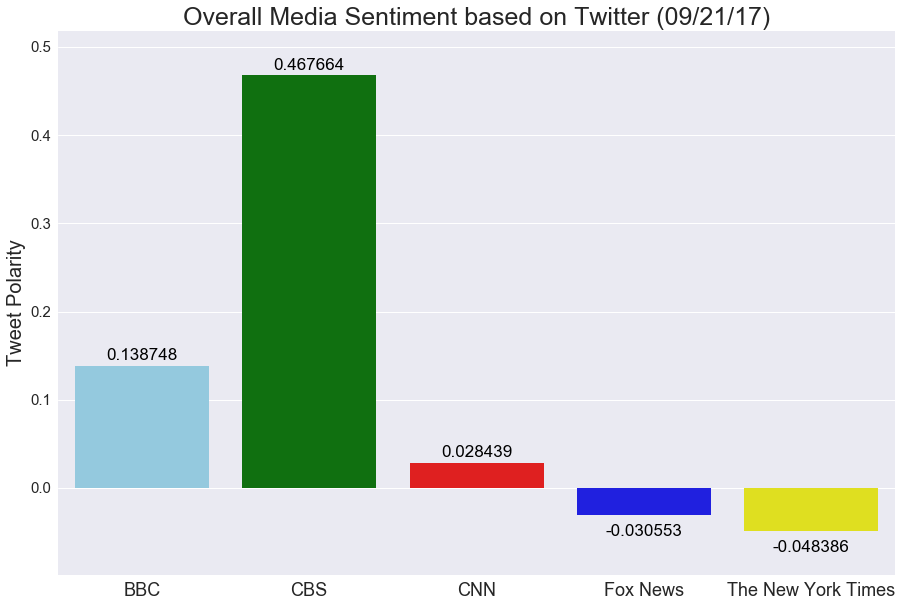

In [5]:
df['Compound Sentiments'] = df['Compound Sentiments'].astype(float)
aggSen = df.groupby('User').mean()['Compound Sentiments']
aggSen_df = pd.DataFrame(aggSen)
plt.figure(figsize=(15,10))
x=aggSen_df.index
y=aggSen_df['Compound Sentiments']
yMax = aggSen_df['Compound Sentiments'].max() + 0.05
yMin = aggSen_df['Compound Sentiments'].min() - 0.05
ax = sns.barplot(x, y, palette=colorLst)
for n, (label, y) in enumerate(zip(x, y)):
    if y <= 0:
        ax.annotate(
            s='{:f}'.format((y)), xy=(n, y - 0.03), ha='center',va='center',
            xytext=(0,10), color='k', textcoords='offset points', size=17)
    else:
        ax.annotate(
            s='{:f}'.format((y)), xy=(n, y), ha='center',va='center',
            xytext=(0,10), color='k', textcoords='offset points', size=17) 
ax.set(ylim=(yMin,yMax))
for tick in ax.get_xticklabels():
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontsize(15)
plt.xlabel('')
plt.ylabel('Tweet Polarity', fontsize=20)
plt.title('Overall Media Sentiment based on Twitter (' + dt + ')', fontsize=25)
plt.savefig('SentimentAnalysis_Bar.png')
plt.show()